# Bank Marketing

This dataset is public available for research. The details are described in [Moro et al., 2011]. 
Please include this citation if you plan to use this database:

[Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.

Available at: [pdf] http://hdl.handle.net/1822/14838
            [bib] http://www3.dsi.uminho.pt/pcortez/bib/2011-esm-1.txt

## Input variables:
### bank client data:
* 1 - age (numeric)
* 2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services") 
* 3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
* 4 - education (categorical: "unknown","secondary","primary","tertiary")
* 5 - default: has credit in default? (binary: "yes","no")
* 6 - balance: average yearly balance, in euros (numeric) 
* 7 - housing: has housing loan? (binary: "yes","no")
* 8 - loan: has personal loan? (binary: "yes","no")

### Related with the last contact of the current campaign:
* 9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
* 10 - day: last contact day of the month (numeric)
* 11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
* 12 - duration: last contact duration, in seconds (numeric)

### Other attributes:
* 13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* 14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
* 15 - previous: number of contacts performed before this campaign and for this client (numeric)
* 16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

### Output variable (desired target):
* 17 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [1]:
from IPython.display import display, HTML

import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
from support_files.adversarial_validation import adversarial_validation
from support_files.categorical_dist_test import categorical_dist_test
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

pd.set_option("display.max_columns", 150, "display.max_colwidth", 150)
pd.options.display.max_rows = 1000

In [2]:
# Show all columns
pd.set_option('display.max_columns', None)

# Option for wider notebook cells
display(HTML(data="""
<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
dataset = pd.read_csv("./data/bank-full.csv", sep=";")

In [4]:
dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
dataset["Month"] = dataset["month"].map({"jan":1, "feb":2, "mar":3, "apr":4, "may":5, "jun":6, "jul":7, "aug":8, 
                                          "sep":9, "oct":10, "nov":11, "dec":12})
dataset["default_in_loan"] = dataset["default"].map({'no':0, 'yes':1})
dataset["housing_loan"] = dataset["housing"].map({'no':0, 'yes':1})
dataset["personal_loan"] = dataset["loan"].map({'no':0, 'yes':1})
dataset["prob_outcome"] = np.where(dataset["poutcome"] == "success", 1, 0)
dataset["target"] = dataset["y"].map({'no':0, 'yes':1})

dataset = dataset.drop(["month","default","housing","loan", "poutcome","y"], axis=1)

dataset['id'] = range(len(dataset))

In [6]:
categorical_vars =[]
numerical_vars=[]
for i in dataset.drop(["target","id"], axis=1).columns.tolist():
    if dataset[i].dtype == 'O':
        categorical_vars.append(i)
    else:
        numerical_vars.append(i)

In [7]:
dataset.head()

,age,job,marital,education,balance,contact,day,duration,campaign,pdays,previous,Month,default_in_loan,housing_loan,personal_loan,prob_outcome,target,id
0,58,management,married,tertiary,2143,unknown,5,261,1,-1,0,5,0,1,0,0,0,0
1,44,technician,single,secondary,29,unknown,5,151,1,-1,0,5,0,1,0,0,0,1
2,33,entrepreneur,married,secondary,2,unknown,5,76,1,-1,0,5,0,1,1,0,0,2
3,47,blue-collar,married,unknown,1506,unknown,5,92,1,-1,0,5,0,1,0,0,0,3
4,33,unknown,single,unknown,1,unknown,5,198,1,-1,0,5,0,0,0,0,0,4


#### Get train and test set from the original dataset

In [8]:
X_train, X_test, y_train, y_test = train_test_split(dataset, dataset.target, test_size=0.3, random_state=55555)

In [9]:
data_train = X_train.copy()
data_train["target"] = y_train

data_test = X_test.copy()
data_test["target"] = y_test

In [10]:
print(data_train.target.mean())
print(data_test.target.mean())
print()
print(data_train.target.sum())
print(data_test.target.sum())

0.11748348974626346
0.11582129165437924

3718
1571


#### We need to perform 2 steps:
* We have an event rate of ~11% in both train and test samples - we will balance these samples with 2:1 odds (2 parts non-event, 1 part event)
* Then, we will perform adversarial validation on the obtained samples to check: <br>
    1 - If the samples come from the same distribution of the population they were samples from <br>
    2 - If the sampled population in the train set comes from the same distribution of the test set:
* If they don't come from the same distribution we will choose the observations more similar to the ones in the population/test set

#### Check numerical features

In [11]:
# identify features
features = [f for f in list(dataset) if f not in categorical_vars+["target"]]

In [12]:
adv = adversarial_validation(data_train, data_test, features,
                        "target", "id", 
                        RandomForestClassifier( n_estimators=200, max_depth=10, n_jobs = -1, random_state=55555 ))

In [13]:
adv_val_set, predictions = adv.check_dist()

AUC is: 0.49983242669846534


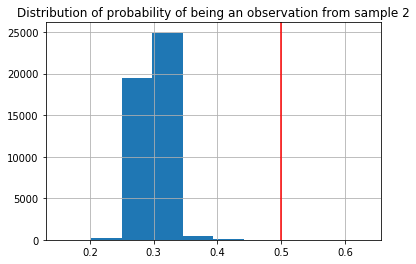

In [16]:
adv_val_set_probs = adv.get_scored_obs(adv_val_set, predictions, get_plot=True)

#### Check categorical features

In [14]:
categorical_vars

['job', 'marital', 'education', 'contact']

In [15]:
results = categorical_dist_test(data_train, data_test, categorical_vars, p_value=0.05)
results

Variables with unequal distribution: 


,variable,p_value
0,job,1.272525e-11
2,education,5.306264e-04


#### If we have different distributions on the samples we can:
* Remove observations with low probability from sample_1 (making sample_1 more similar to sample_2)
* Transfer observations with low probability on sample_1 to sample_2 (making sample_2 more similar to sample_1)
* Choose another sample_2